In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.3.1


In [4]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [5]:
train_data.shape

(1460, 81)

In [6]:
test_data.shape

(1459, 80)

In [7]:
train_data.iloc[0:4,[1,2,3,-3,-2,-1]]

,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,WD,Normal,208500
1,20,RL,80.0,WD,Normal,181500
2,60,RL,68.0,WD,Normal,223500
3,70,RL,60.0,WD,Abnorml,140000


In [8]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [9]:
all_features.shape

(2919, 79)

In [10]:
numeric_features = all_features.dtypes[all_features.dtypes !="object"].index
all_features[numeric_features] = all_features[numeric_features].apply(
        lambda x : (x-x.mean())/(x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [11]:
all_features.shape

(2919, 79)

In [12]:
all_features = pd.get_dummies(all_features, dummy_na =True)

In [13]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype = torch.float32)
test_features = torch.tensor(all_features[n_train:].values , dtype = torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values, dtype = torch.float32).view(-1,1)

In [14]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    plt.figure(figsize=figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [15]:
def Linear(features_num, drop_prob ):
    net = nn.Sequential(
        nn.Linear(features_num,1),
        #nn.Dropout(droup_pred),
        #nn.Linear(2,1)
    )
    return net

In [16]:
loss = nn.MSELoss()
def log_Mse(net , features, labels):
    with torch.no_grad():
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2*loss( clipped_preds.log(), labels.log()).mean())
    return rmse

In [83]:
def train(num_epochs, train_features, train_labels, test_features, test_labels, 
                          net,batch_size,lr,weight_decay):
    train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_l ,test_l =[], []
    optimizer = torch.optim.SGD(params=net.parameters(), lr=lr, weight_decay=weight_decay,momentum = 0.1)
    train_iter = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle= True)
    for i in range(num_epochs):
        
        for x,y in train_iter:
            net.train()
            l = loss(net(x),y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_l.append(log_Mse(net, train_features, train_labels))
        if test_features is not None:
            net.eval()
            test_l.append(log_Mse(net, test_features, test_labels))
    return train_l,test_l

In [18]:
def get_f_fold(i, k, train_features, train_labels):
    assert k>1
    fold_size = train_features.shape[0]//k
    features_train, labels_train = None,None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        features_part,labels_part = train_features[idx,:],train_labels[idx]
        if i == j:
            features_valid,labels_valid = features_part,labels_part
        elif features_train is None:
            features_train,labels_train = features_part,labels_part
        else:
            features_train = torch.cat((features_train,features_part),dim=0)
            labels_train = torch.cat((labels_train,labels_part),dim=0)
    return features_train, labels_train, features_valid,labels_valid

In [19]:
def f_fold(k, x_train, y_train, num_epochs,batch_size,lr,weight_decay,drop_prob):
    train_l_sum,test_l_sum =0,0
    for i in range(k):
        data = get_f_fold(i,k,x_train, y_train)
        net = Linear(x_train.shape[1],drop_prob)
        train_l,test_l = train(num_epochs,*data,net,batch_size,lr,weight_decay)
        train_l_sum += train_l[-1]
        test_l_sum += test_l[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_l, 'epochs', 'rmse',
                         range(1, num_epochs + 1), test_l,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_l[-1], test_l[-1]))
    return train_l_sum/k, test_l_sum/k

fold 0, train rmse 0.189432, valid rmse 0.225927
fold 1, train rmse 0.188016, valid rmse 0.180181
fold 2, train rmse 0.189299, valid rmse 0.197801
fold 3, train rmse 0.180301, valid rmse 0.236182
fold 4, train rmse 0.183195, valid rmse 0.236948
fold 5, train rmse 0.189006, valid rmse 0.193469
fold 6, train rmse 0.190772, valid rmse 0.203863
fold 7, train rmse 0.191779, valid rmse 0.189673
fold 8, train rmse 0.175874, valid rmse 0.256268
fold 9, train rmse 0.187582, valid rmse 0.214119
10-fold validation: avg train rmse 0.186526, avg valid rmse 0.213443


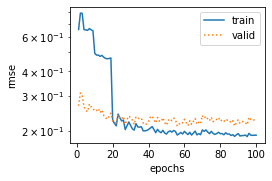

In [89]:
k, num_epochs, lr, weight_decay, batch_size ,drop_prob = 10, 100, 0.0058, 0, 64,0.6
train_l, valid_l = f_fold(k,train_features,train_labels,num_epochs,batch_size ,lr,weight_decay,drop_prob)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

In [90]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size, drop_prob):
    net = Linear(train_features.shape[1],drop_prob)
    train_ls, _ = train(num_epochs, train_features, train_labels, None, None,
                        net,batch_size,lr,weight_decay)
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./first_housePrice.csv', index=False)

In [91]:
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size,drop_prob)

train rmse 0.187145
